In [7]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [9]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


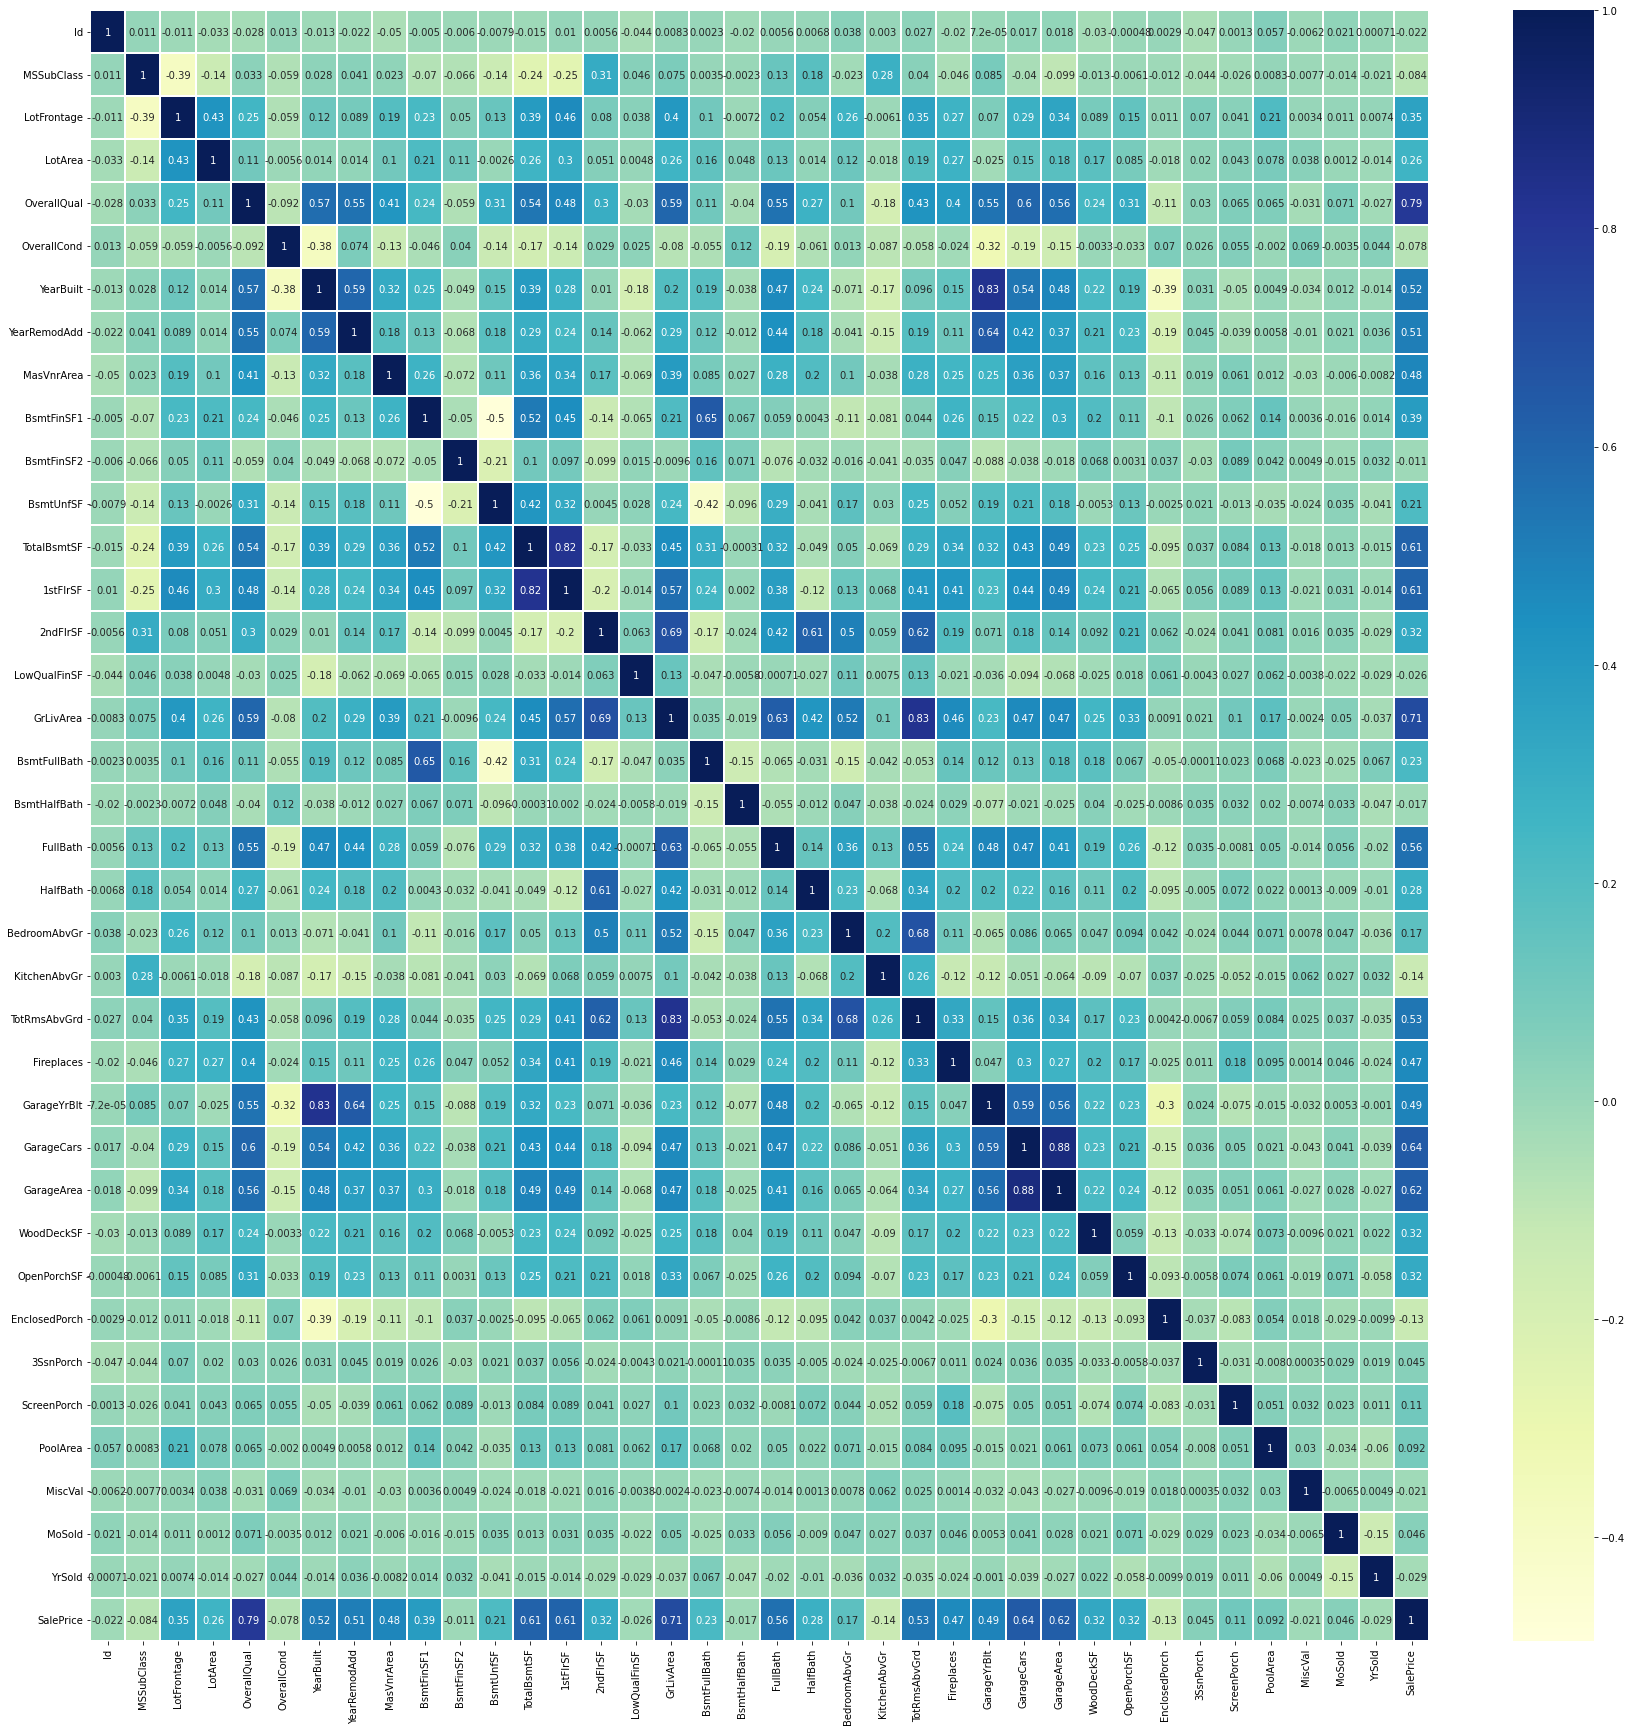

In [12]:
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(df_train.corr(), annot=True, cmap="YlGnBu", linewidths=0.1, annot_kws={"fontsize":10});

<AxesSubplot:>

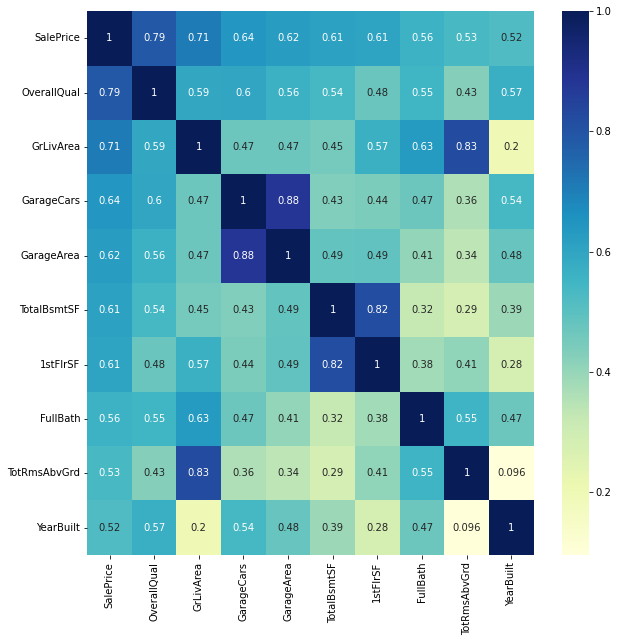

In [22]:
cols = df_train.corr().nlargest(10, 'SalePrice')['SalePrice'].index
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_train[cols].corr(), cmap="YlGnBu", annot=True, annot_kws={'size': 10})



In [31]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum())/(df_train.isnull().count())
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
...,...,...
ExterQual,0,0.000000
Exterior2nd,0,0.000000
Exterior1st,0,0.000000
RoofMatl,0,0.000000


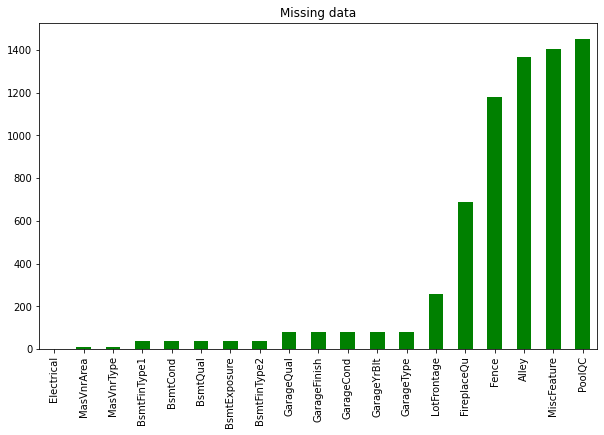

In [40]:
# aqui voy
fig, ax = plt.subplots(figsize=(10,6))
deleted_data = missing_data[missing_data['Total'] >= 1]['Total'].copy()
deleted_data.sort_values(inplace=True)
ax.set_title('Missing data')
ax = deleted_data.plot.bar(color='green')

In [41]:
df_train = df_train.drop((missing_data[missing_data['Total'] >= 1]).index,axis = 1)
if not df_train.isnull().sum().max():
    print(f'Dataset hasnt zeros')
else:
    print(f'Dataset has {df_train.isnull().sum().max()} zeros')

Dataset hasnt zeros


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

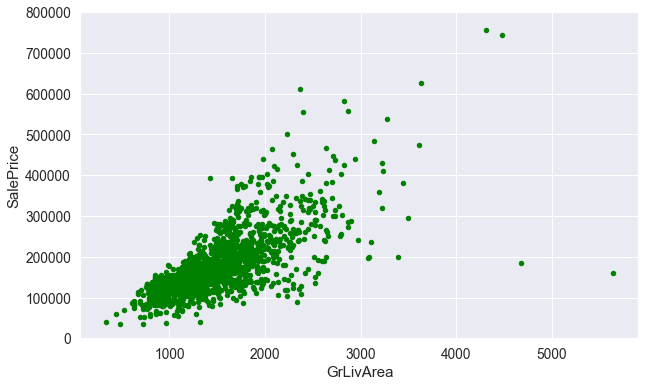

In [19]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), color='green', figsize=(10,6))

In [20]:
# cloud points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [21]:
# deleting points
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

In [22]:
x = df_train.drop('Id', inplace=True, axis=1) 
x = df_train.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object']) # select all the columns except the columns with data type object
y = df_train['SalePrice']

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x.to_numpy(), y.to_numpy(), test_size=0.25, random_state=42)

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# # Imputation transformer for completing missing values. (nan to mean)
# x_train = imp_mean.fit_transform(x_train) 
# x_test = imp_mean.fit_transform(x_test)

In [24]:
max_depth = [3, 4, 5, 6, 7, 8, 10]
models = {}
errors = {}
count = 0
for a in max_depth:
    decision_tree = DecisionTreeRegressor(max_depth=a).fit(x_train, y_train)
    predicted_dt = decision_tree.predict(x_test)
    errors[count] = mean_absolute_error(y_test, predicted_dt)
    models[count] = decision_tree
    count +=1
    print(f'Mean absolute error of decision three model is {mean_absolute_error(y_test, predicted_dt)}')
min_error = [k for k,v in errors.items() if v == min(errors.values())]

Mean absolute error of decision three model is 29781.528368344425
Mean absolute error of decision three model is 28913.333423588705
Mean absolute error of decision three model is 25374.74478326586
Mean absolute error of decision three model is 24974.533496789998
Mean absolute error of decision three model is 23838.056308270603
Mean absolute error of decision three model is 23010.118771090114
Mean absolute error of decision three model is 24711.11536631713


In [25]:
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_train, y_train)}')
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_test, y_test)}')

Square root of DecisionTreeRegressor is 0.9634591714859452
Square root of DecisionTreeRegressor is 0.8296359232212644


In [26]:
n_estimators = [100, 200, 300, 400, 500, 1000]
models = {}
errors = {}
count = 0
for a in n_estimators:
    random_forest = RandomForestRegressor(n_estimators=a, max_depth=10).fit(x_train, y_train)
    predicted_rf = random_forest.predict(x_test)
    errors[count] = mean_absolute_error(y_test, predicted_rf)
    models[count] = random_forest
    count +=1
    print(f'Mean absolute error of decision three model is {mean_absolute_error(y_test, predicted_rf)}')
min_error = [k for k,v in errors.items() if v == min(errors.values())]

Mean absolute error of decision three model is 16757.264572275017
Mean absolute error of decision three model is 16858.033495726853
Mean absolute error of decision three model is 16586.481538262095
Mean absolute error of decision three model is 16751.147430560548
Mean absolute error of decision three model is 16711.799706270052
Mean absolute error of decision three model is 16735.90227838149


In [27]:
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_train, y_train)}')
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_test, y_test)}')

Square root of RandomForestRegressor is 0.9788538190989328
Square root of RandomForestRegressor is 0.9035315769732173


XGBOOST

In [28]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_depth = [3, 4, 5, 6, 7, 8, 10]
models = {}
errors = {}
count = 0
for a, b in zip(n_estimators, max_depth):
    xgboost = XGBRegressor(n_estimators=a, max_depth=b, eta=0.1, subsample=0.7, colsample_bytree=0.8).fit(x_train, y_train)
    predicted_xg = xgboost.predict(x_test)
    errors[count] = mean_absolute_error(y_test, predicted_xg)
    models[count] = xgboost
    count +=1
    print(f'Mean absolute error of decision three model is {mean_absolute_error(y_test, predicted_xg)}')
min_error = [k for k,v in errors.items() if v == min(errors.values())]

Mean absolute error of decision three model is 16878.65230094178
Mean absolute error of decision three model is 16319.207801797946
Mean absolute error of decision three model is 16310.191770119864
Mean absolute error of decision three model is 16182.99194135274
Mean absolute error of decision three model is 16137.273084332192
Mean absolute error of decision three model is 15887.465325342466


In [29]:
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_train, y_train)}')
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_test, y_test)}')

Square root of XGBRegressor is 0.9999949915045999
Square root of XGBRegressor is 0.9158612341431442


In [30]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

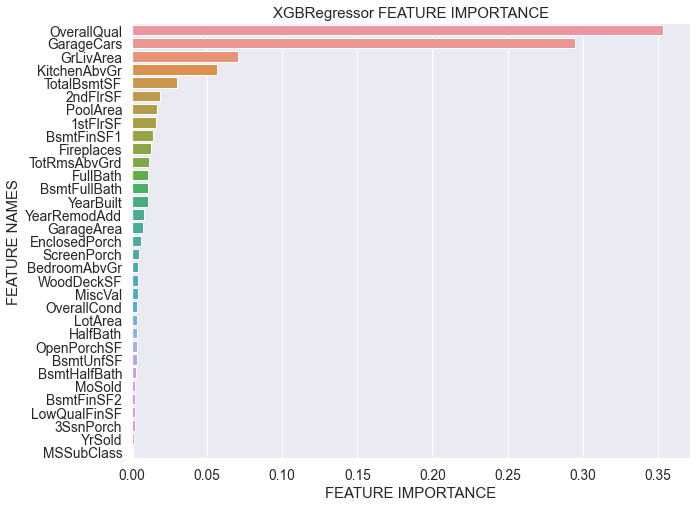

In [31]:
plot_feature_importance(xgboost.feature_importances_,x.columns,'XGBRegressor')

In [32]:
test_csv = pd.read_csv("data/test.csv")
sub_csv = pd.read_csv("data/sample_submission.csv")
sub_csv.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [33]:
# select all the columns except the columns with data type object
test_csv = test_csv.drop(['Id'], axis=1).select_dtypes(exclude=['object']) 
# delete difference between columns of DataFrames
test_csv = test_csv.drop(test_csv.columns.difference(x.columns), axis=1)

In [34]:
# look at where 'SalePrices' is null and replace df_train
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
test_csv = imp_mean.fit_transform(test_csv) 

In [35]:
models = [decision_tree, random_forest, xgboost]
for model in models:
    RMS = mean_squared_error(np.log(sub_csv['SalePrice']), np.log(model.predict(test_csv)), squared=False)
    print(f'Root-Mean-Squared-Error of {type(model).__name__} is {RMS}')
    
    data = pd.concat([sub_csv['Id'], pd.Series(model.predict(test_csv))], axis=1)
    data.rename(columns={"Id": "Id", 0: "SalePrice"}, inplace=True)
    data.to_csv(f'{type(model).__name__}_submission.csv', index=False)
#     data.info()
    print(f'Submission of {type(model).__name__} was successfully saved!')

Root-Mean-Squared-Error of DecisionTreeRegressor is 0.39368817695736086
Submission of DecisionTreeRegressor was successfully saved!
Root-Mean-Squared-Error of RandomForestRegressor is 0.3553931252058867
Submission of RandomForestRegressor was successfully saved!
Root-Mean-Squared-Error of XGBRegressor is 0.3747812953523398
Submission of XGBRegressor was successfully saved!


In [37]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f ./RandomForestRegressor_submission.csv -m "test submission"

100%|██████████████████████████████████████| 33.7k/33.7k [00:01<00:00, 20.3kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques